 HYBRID PIPELINE 
 STEP 1: K-FOLD (FAST GRID) 

Fold 1
 train_score: 6.555862068965676
 test_score: 7.9893103448274925
 ratio: 1.2186513780769601

Fold 2
 train_score: 9.57551724137944
 test_score: 19.972758620689735
 ratio: 2.0858151175771344

Fold 3
 train_score: 10.674137931034625
 test_score: 17.671379310344822
 ratio: 1.6555322241963915

Fold 4
 train_score: 7.462413793103347
 test_score: 5.521379310344981
 ratio: 0.7398918719098314

Fold 5
 train_score: 8.564827586206759
 test_score: 14.206896551724046
 ratio: 1.6587486915210725

 STEP 2: HOLDOUT (FULL GRID) 


Holdout calibration:   0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]


 STEP 3: FULL CALIBRATION 


Full calibration:   0%|          | 0/1200 [00:00<?, ?it/s]


Final parameters:
  beta_handler_patron : 0.029285714285714286
  beta_staff_staff : 0.05
  prob_food_contamination : 0.1
  contamination_size_mean : 35.0
  contamination_size_std : 30
Calibration score: 9.655172413793158


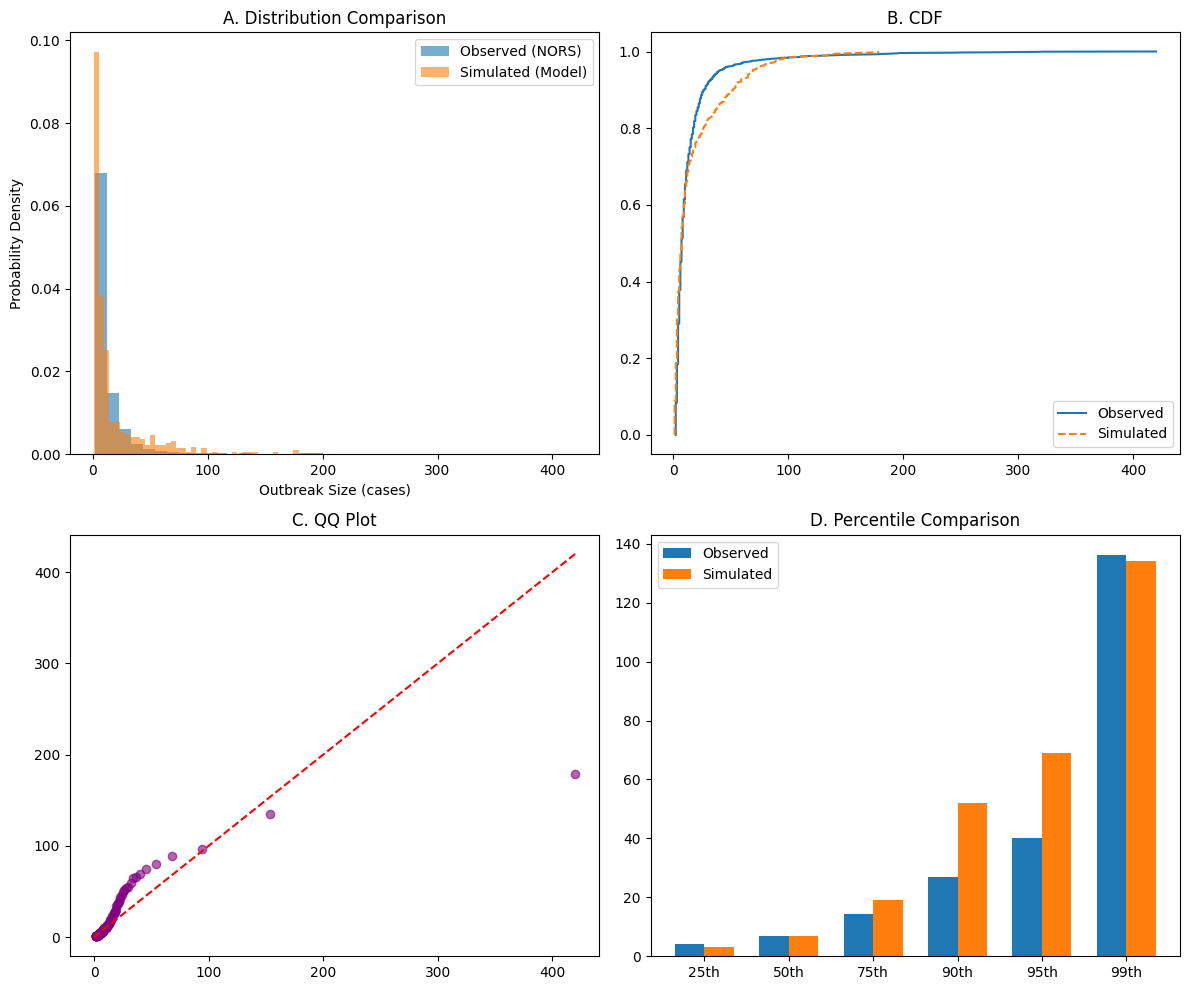

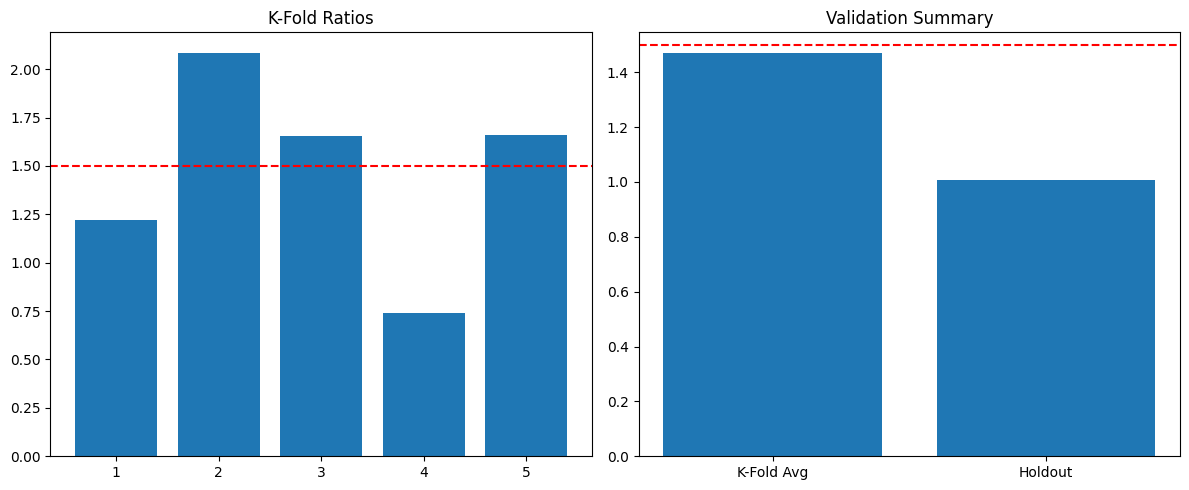


 EXTRA VALIDATION METRICS
KS statistic: 0.11765656565656565
KS p-value: 2.8300437853994425e-05
Wasserstein: 5.541575757575751
Overdispersion: 0.9512694807917121
95th pct error: 29.0
99th pct error: 2.2500000000002274
Bootstrap SD: 1.1236252905662099

Pipeline finished.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
from scipy.stats import ks_2samp, wasserstein_distance


# SIMULATION MODEL


def simulate_restaurant_outbreak_v3(
        n_food_handlers=None, n_other_staff=None, init_infected=None,
        patrons_per_shift=None, shift_hours=8, shifts_per_day=2,
        patrons_per_handler=30, max_days=5, latent_period=1.0,
        infectious_period=3.0, prob_symptomatic=0.7,
        beta_staff_staff=0.1, beta_handler_patron=0.02,
        beta_other_patron=0.001, prob_food_contamination=0.15,
        contamination_size_mean=45, contamination_size_std=30):

    if n_food_handlers is None:
        n_food_handlers = np.random.choice([3,4,5,6,7], p=[0.1,0.2,0.4,0.2,0.1])
    if n_other_staff is None:
        n_other_staff = np.random.choice([3,4,5,6], p=[0.2,0.3,0.3,0.2])
    if init_infected is None:
        init_infected = np.random.choice([1,2,3], p=[0.6,0.3,0.1])
    if patrons_per_shift is None:
        patrons_per_shift = np.random.choice([100,125,150,175,200], p=[0.2,0.2,0.3,0.2,0.1])

    total_staff = n_food_handlers + n_other_staff
    staff_states = ['S'] * total_staff
    staff_infection_day = [None] * total_staff
    is_handler = [True]*n_food_handlers + [False]*n_other_staff

    idxs = np.random.choice(total_staff, init_infected, replace=False)
    for x in idxs:
        staff_states[x] = 'E'
        staff_infection_day[x] = 0.0

    staff_inf_count = init_infected
    pat_inf = 0

    for day in range(max_days):

        for i in range(total_staff):
            if staff_states[i] == 'E':
                if (day - staff_infection_day[i]) >= latent_period:
                    if np.random.rand() < prob_symptomatic:
                        staff_states[i] = 'Is'
                    else:
                        staff_states[i] = 'Ia'

            elif staff_states[i] in ['Ia','Is']:
                if (day - staff_infection_day[i]) >= (latent_period + infectious_period):
                    staff_states[i] = 'R'

        inf_staff = []
        sus_staff = []
        for ii in range(total_staff):
            if staff_states[ii] in ['Ia','Is']:
                inf_staff.append(ii)
            elif staff_states[ii] == 'S':
                sus_staff.append(ii)

        if len(inf_staff) > 0 and len(sus_staff) > 0:
            for s in sus_staff:
                for z in inf_staff:
                    if staff_states[z] == 'Is' and np.random.rand() < 0.5:
                        continue
                    if np.random.rand() < beta_staff_staff:
                        staff_states[s] = 'E'
                        staff_infection_day[s] = day + np.random.uniform(0,1)
                        staff_inf_count += 1
                        break

        for sh in range(shifts_per_day):
            inf_handlers = []
            inf_other = []
            for i in range(total_staff):
                if staff_states[i] in ['Ia','Is']:
                    if staff_states[i]=='Is' and np.random.rand()<0.5:
                        continue
                    if is_handler[i]:
                        inf_handlers.append(i)
                    else:
                        inf_other.append(i)

            for hh in inf_handlers:
                pat_inf += np.random.binomial(patrons_per_handler, beta_handler_patron)

            if len(inf_other)>0:
                pat_inf += np.random.binomial(patrons_per_shift,
                                              beta_other_patron*len(inf_other))

            if len(inf_handlers)>0:
                if np.random.rand() < prob_food_contamination:
                    if contamination_size_mean > 0:
                        sig = np.sqrt(np.log(1+(contamination_size_std/contamination_size_mean)**2))
                        mu = np.log(contamination_size_mean) - sig**2/2
                        sizee = int(np.random.lognormal(mu, sig))
                        sizee = max(10, min(sizee, int(patrons_per_shift*0.9)))
                        pat_inf += sizee

    return staff_inf_count + pat_inf



# SCORING

def calculate_score(real_sizes, sim_sizes):
    r = np.percentile(real_sizes, [10,25,50,75,90,95,99])
    s = np.percentile(sim_sizes,  [10,25,50,75,90,95,99])
    w = np.array([1,1.5,2.5,1.5,2,2.5,3.5])
    return np.average(np.abs(r-s), weights=w)



# FULL CALIBRATION

def calibrate_model(train_sizes, n_sims=500, desc="Calibrating full grid"):

    betas_handler = np.linspace(0.015,0.035,8)
    probs = np.linspace(0.10,0.22,6)
    means = np.linspace(35,65,5)
    betas_staff = [0.01, 0.03, 0.05, 0.1, 0.2]

    best_score = 999999
    best_params = None
    best_sim = None

    total_it = len(betas_handler)*len(probs)*len(means)*len(betas_staff)
    pbar = tqdm(total=total_it, desc=desc)

    for bh in betas_handler:
        for p in probs:
            for m in means:
                for bs in betas_staff:

                    sims = []
                    for _ in range(n_sims):
                        sims.append(simulate_restaurant_outbreak_v3(
                            beta_handler_patron=bh,
                            prob_food_contamination=p,
                            contamination_size_mean=m,
                            contamination_size_std=30,
                            beta_staff_staff=bs
                        ))
                    sims = np.array(sims)

                    sc = calculate_score(train_sizes, sims)

                    if sc < best_score:
                        best_score = sc
                        best_params = {
                            'beta_handler_patron': bh,
                            'beta_staff_staff': bs,
                            'prob_food_contamination': p,
                            'contamination_size_mean': m,
                            'contamination_size_std': 30
                        }
                        best_sim = sims

                    pbar.update(1)

    pbar.close()
    return best_params, best_sim, best_score



# FAST GRID FOR K-FOLD (NOW INCLUDES beta_staff_staff)

def calibrate_fast_for_kfold(train_sizes):

    betas_handler = np.linspace(0.015,0.035,5)
    probs = np.linspace(0.10,0.22,4)
    means = np.linspace(35,65,3)
    betas_staff = [0.01, 0.05, 0.1, 0.2]

    best_sc = 999999
    best_par = None

    for bh in betas_handler:
        for p in probs:
            for m in means:
                for bs in betas_staff:

                    sims = []
                    for _ in range(200):
                        sims.append(simulate_restaurant_outbreak_v3(
                            beta_handler_patron=bh,
                            prob_food_contamination=p,
                            contamination_size_mean=m,
                            contamination_size_std=30,
                            beta_staff_staff=bs
                        ))
                    sims = np.array(sims)

                    sc = calculate_score(train_sizes, sims)

                    if sc < best_sc:
                        best_sc = sc
                        best_par = {
                            'beta_handler_patron': bh,
                            'prob_food_contamination': p,
                            'contamination_size_mean': m,
                            'beta_staff_staff': bs
                        }

    return best_par, best_sc



# STEP 1 — K-FOLD

def step1_kfold_validation(all_sizes, k=5):

    print("="*70)
    print(" STEP 1: K-FOLD (FAST GRID) ")
    print("="*70)

    np.random.seed(42)
    idx = np.random.permutation(len(all_sizes))
    fold_size = len(all_sizes)//k

    results = []

    for fold in range(k):
        st = fold*fold_size
        en = (fold+1)*fold_size if fold < k-1 else len(all_sizes)

        test_idx = idx[st:en]
        train_idx = np.concatenate([idx[:st], idx[en:]])

        train_vals = all_sizes[train_idx]
        test_vals  = all_sizes[test_idx]

        print("\nFold", fold+1)

        par, train_sc = calibrate_fast_for_kfold(train_vals)

        out = []
        for _ in range(200):
            out.append(simulate_restaurant_outbreak_v3(**par))
        out = np.array(out)

        test_sc = calculate_score(test_vals, out)
        ratio = test_sc/train_sc

        print(" train_score:", train_sc)
        print(" test_score:", test_sc)
        print(" ratio:", ratio)

        results.append({
            'fold': fold+1,
            'train_score': train_sc,
            'test_score': test_sc,
            'ratio': ratio,
            'params': par
        })

    pd.DataFrame(results).to_csv("step1_kfold_results.csv", index=False)

    return results, np.mean([r['ratio'] for r in results]), np.std([r['ratio'] for r in results])



# STEP 2 — HOLDOUT (FULL GRID)


def step2_holdout_validation(all_sizes):

    print("\n" + "="*70)
    print(" STEP 2: HOLDOUT (FULL GRID) ")
    print("="*70)

    np.random.seed(123)
    n_train = int(len(all_sizes)*0.8)
    shuf = np.random.permutation(len(all_sizes))

    train_vals = all_sizes[shuf[:n_train]]
    test_vals  = all_sizes[shuf[n_train:]]

    par, sim_train, train_sc = calibrate_model(train_vals, n_sims=300,
                                               desc="Holdout calibration")

    out = []
    for _ in tqdm(range(300)):
        out.append(simulate_restaurant_outbreak_v3(**par))
    out = np.array(out)

    test_sc = calculate_score(test_vals, out)
    ratio = test_sc/train_sc

    return par, sim_train, train_vals, out, test_vals, ratio



# STEP 3 — FULL CALIBRATION (FINAL PARAMS)

def step3_full_calibration(all_sizes):

    print("\n" + "="*70)
    print(" STEP 3: FULL CALIBRATION ")
    print("="*70)

    par, sim_sizes, sc = calibrate_model(all_sizes, n_sims=500,
                                         desc="Full calibration")

    print("\nFinal parameters:")
    for kk,vv in par.items():
        print(" ", kk, ":", vv)
    print("Calibration score:", sc)

    return par, sim_sizes



# PLOTS (UNCHANGED)

def create_publication_plots(obs, sim, kfold_results, holdout_ratio):

    fig, axes = plt.subplots(2,2, figsize=(12,10))
    ax1, ax2, ax3, ax4 = axes.flatten()

    ax1.hist(obs, bins=40, density=True, alpha=0.6, label="Observed (NORS)")
    ax1.hist(sim, bins=40, density=True, alpha=0.6, label="Simulated (Model)")
    ax1.set_title("A. Distribution Comparison")
    ax1.set_xlabel("Outbreak Size (cases)")
    ax1.set_ylabel("Probability Density")
    ax1.legend()

    sorted_obs = np.sort(obs)
    sorted_sim = np.sort(sim)
    ax2.plot(sorted_obs, np.linspace(0,1,len(sorted_obs)), label="Observed")
    ax2.plot(sorted_sim, np.linspace(0,1,len(sorted_sim)), linestyle="--", label="Simulated")
    ax2.set_title("B. CDF")
    ax2.legend()

    q_obs = np.percentile(obs, np.linspace(0,100,120))
    q_sim = np.percentile(sim, np.linspace(0,100,120))
    ax3.scatter(q_obs, q_sim, alpha=0.6, color="purple")
    ax3.plot([0,max(q_obs)], [0,max(q_obs)], 'r--')
    ax3.set_title("C. QQ Plot")

    pct_list = [25,50,75,90,95,99]
    obs_p = np.percentile(obs, pct_list)
    sim_p = np.percentile(sim, pct_list)
    x = np.arange(len(pct_list))
    width = 0.35
    ax4.bar(x-width/2, obs_p, width, label="Observed")
    ax4.bar(x+width/2, sim_p, width, label="Simulated")
    ax4.set_xticks(x)
    ax4.set_xticklabels([f"{p}th" for p in pct_list])
    ax4.set_title("D. Percentile Comparison")
    ax4.legend()

    plt.tight_layout()
    plt.show()

    ratios = [r["ratio"] for r in kfold_results]
    folds  = [r["fold"] for r in kfold_results]

    fig, (axA, axB) = plt.subplots(1,2, figsize=(12,5))
    axA.bar(folds, ratios)
    axA.axhline(1.5, linestyle="--", color="red")
    axA.set_title("K-Fold Ratios")

    axB.bar(["K-Fold Avg","Holdout"], [np.mean(ratios), holdout_ratio])
    axB.axhline(1.5, linestyle="--", color="red")
    axB.set_title("Validation Summary")

    plt.tight_layout()
    plt.show()



# EXTRA METRICS

def extra_validation_metrics(obs, sim):

    print("\n" + "="*70)
    print(" EXTRA VALIDATION METRICS")
    print("="*70)

    ks_stat, ks_p = ks_2samp(obs, sim)
    wd = wasserstein_distance(obs, sim)

    pct_list = [10,25,50,75,90,95,99]
    obs_p = np.percentile(obs, pct_list)
    sim_p = np.percentile(sim, pct_list)
    pct_err = np.abs(obs_p - sim_p)
    tail_95 = pct_err[-2]
    tail_99 = pct_err[-1]

    var_ratio = np.var(sim) / np.var(obs)

    boot = []
    for _ in range(200):
        boot.append(np.mean(np.random.choice(sim, size=len(sim), replace=True)))
    boot_std = np.std(boot)

    print("KS statistic:", ks_stat)
    print("KS p-value:", ks_p)
    print("Wasserstein:", wd)
    print("Overdispersion:", var_ratio)
    print("95th pct error:", tail_95)
    print("99th pct error:", tail_99)
    print("Bootstrap SD:", boot_std)

    return {
        "ks_stat": ks_stat,
        "ks_p": ks_p,
        "wd": wd,
        "var_ratio": var_ratio,
        "tail95": tail_95,
        "tail99": tail_99,
        "boot_sd": boot_std
    }



# MAIN PIPELINE

def main():

    print("="*70)
    print(" HYBRID PIPELINE ")
    print("="*70)

    df = pd.read_csv("NORS_JS1.csv", header=None)
    sizes = df[0].dropna().astype(int).values

    kfold_results, kmean, kstd = step1_kfold_validation(sizes)

    hold_params, sim_train, train_vals, sim_test, test_vals, hold_ratio = \
        step2_holdout_validation(sizes)

    final_params, sim_full = step3_full_calibration(sizes)

    create_publication_plots(sizes, sim_full, kfold_results, hold_ratio)

    extra_validation_metrics(sizes, sim_full)

    print("\nPipeline finished.")



if __name__ == "__main__":
    main()


Running policy simulations...
Summarizing results...


,Scenario,Median,2.5%,97.5%,% Reduction,Infections Averted
0,A,4.0,1.0,88.050,0.0%,0.0
1,B_0.3,4.0,1.0,87.050,0.0%,0.0
2,C_0.3,4.0,1.0,72.000,0.0%,0.0
3,D_0.3,3.0,1.0,78.050,25.0%,1.0
4,B_0.6,3.0,1.0,74.050,25.0%,1.0
5,C_0.6,4.0,1.0,84.000,0.0%,0.0
6,D_0.6,2.0,1.0,70.000,50.0%,2.0
7,B_1.0,2.0,1.0,74.050,50.0%,2.0
8,C_1.0,3.0,1.0,78.075,25.0%,1.0
9,D_1.0,2.0,1.0,61.050,50.0%,2.0


/tmp/ipython-input-3062285065.py:227: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=keys)


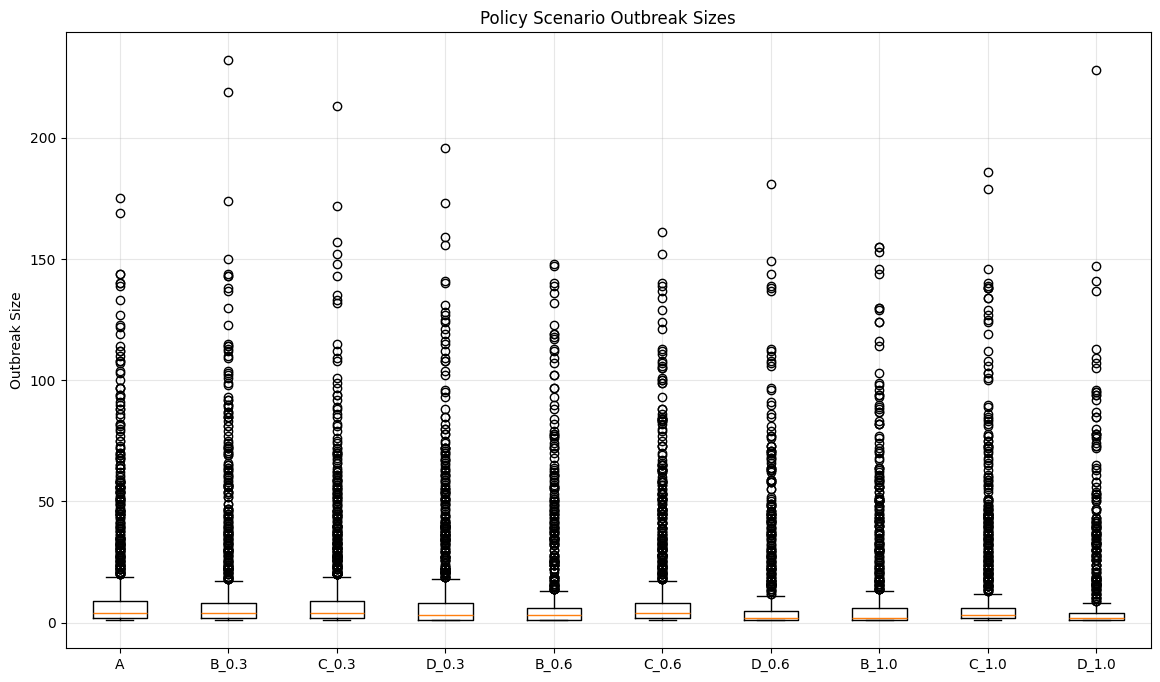

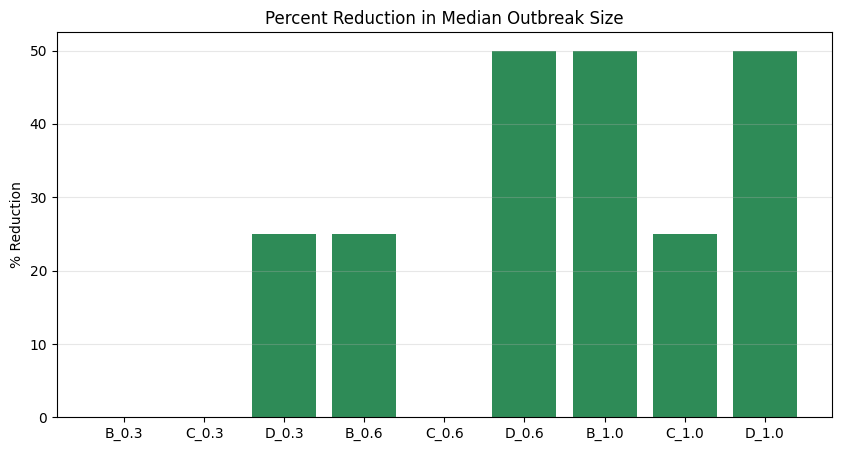

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# ============================================================
# FINAL CALIBRATED PARAMETERS
# ============================================================
BETA_HP   = 0.029285714285714286   # beta_handler_patron
BETA_SS   = 0.05                   # beta_staff_staff
P_CONTAM  = 0.10                   # prob_food_contamination
CONTAM_MEAN = 35
CONTAM_STD  = 30


# ============================================================
# SIMULATION MODEL (policy-ready version)
# ============================================================
def simulate_outbreak_policy(
    # staff + restaurant defaults
    n_food_handlers=5,
    n_other_staff=5,
    init_infected=1,
    patrons_per_shift=150,
    patrons_per_handler=30,
    shifts_per_day=2,
    max_days=5,

    # disease
    latent_period=1.0,
    infectious_period=3.0,
    prob_symptomatic=0.7,

    # FINAL calibrated parameters
    beta_staff_staff=BETA_SS,
    beta_handler_patron=BETA_HP,
    beta_other_patron=0.001,
    prob_food_contamination=P_CONTAM,
    contamination_size_mean=CONTAM_MEAN,
    contamination_size_std=CONTAM_STD,

    # policy controls
    policy_exclusion=False,
    policy_hygiene=False,
    compliance=0.0,
    xi_max=0.4,
    omega=0.2,
    beta_mult=0.70        # hygiene reduces transmission by 30%
):

    # --- Apply hygiene scaling ---
    if policy_hygiene:
        beta_ss_eff = beta_staff_staff * (1 - (1-beta_mult)*compliance)
        beta_hp_eff = beta_handler_patron * (1 - (1-beta_mult)*compliance)
    else:
        beta_ss_eff = beta_staff_staff
        beta_hp_eff = beta_handler_patron

    # --- Apply exclusion ---
    xi_eff = compliance * xi_max if policy_exclusion else 0

    # --- Staff initialization ---
    total_staff = n_food_handlers + n_other_staff
    staff_states = ['S'] * total_staff
    staff_infection_day = [None] * total_staff
    is_handler = [True]*n_food_handlers + [False]*n_other_staff
    excluded = [False]*total_staff

    idx = np.random.choice(total_staff, init_infected, replace=False)
    for i in idx:
        staff_states[i] = 'E'
        staff_infection_day[i] = 0.0

    total_staff_inf = init_infected
    total_pat_inf = 0


    # ------------------------------------------------------------
    # MAIN SIMULATION LOOP (days)
    # ------------------------------------------------------------
    for day in range(max_days):

        # disease progression
        for i in range(total_staff):
            if staff_states[i] == 'E':
                if (day - staff_infection_day[i]) >= latent_period:
                    staff_states[i] = 'Is' if np.random.rand() < prob_symptomatic else 'Ia'

            elif staff_states[i] in ['Ia','Is']:
                if (day - staff_infection_day[i]) >= (latent_period + infectious_period):
                    staff_states[i] = 'R'

        # staf exclusion
        if policy_exclusion:
            for i in range(total_staff):
                if staff_states[i] == "Is" and not excluded[i]:
                    if np.random.rand() < xi_eff:
                        excluded[i] = True

            for i in range(total_staff):
                if excluded[i] and np.random.rand() < omega:
                    excluded[i] = False
                    staff_states[i] = 'R'

        # infectious & susceptible lists
        infectious = [
            i for i in range(total_staff)
            if staff_states[i] in ["Ia","Is"] and not excluded[i]
        ]
        susceptible = [
            i for i in range(total_staff)
            if staff_states[i] == "S" and not excluded[i]
        ]

        # STAFF → STAFF
        for s in susceptible:
            for inf in infectious:
                if staff_states[inf] == 'Is' and np.random.rand() < 0.5:
                    continue
                if np.random.rand() < beta_ss_eff:
                    staff_states[s] = "E"
                    staff_infection_day[s] = day + np.random.uniform(0,1)
                    total_staff_inf += 1
                    break

        # SHIFTS
        for sh in range(shifts_per_day):

            infectious_handlers = [
                i for i in infectious if is_handler[i]
                if not (staff_states[i]=="Is" and np.random.rand()<0.5)
            ]
            infectious_other = [
                i for i in infectious if not is_handler[i]
                if not (staff_states[i]=="Is" and np.random.rand()<0.5)
            ]

            # Handler → patron
            for h in infectious_handlers:
                total_pat_inf += np.random.binomial(patrons_per_handler, beta_hp_eff)

            # Other staff → patrons
            if len(infectious_other) > 0:
                total_pat_inf += np.random.binomial(patrons_per_shift,
                                                    beta_other_patron * len(infectious_other))

            # FOOD CONTAMINATION (lognormal size)
            if len(infectious_handlers) > 0:
                if np.random.rand() < prob_food_contamination:
                    sig = np.sqrt(np.log(1+(contamination_size_std/contamination_size_mean)**2))
                    mu  = np.log(contamination_size_mean) - sig**2/2
                    contam_size = int(np.random.lognormal(mu, sig))
                    contam_size = max(10, min(contam_size, int(patrons_per_shift*0.9)))
                    total_pat_inf += contam_size

    return total_staff_inf + total_pat_inf


# ============================================================
# RUN SCENARIOS
# ============================================================
def run_all_policies(N_runs=1500):

    scenarios = {"A": None}
    scenarios["A"] = np.array([
        simulate_outbreak_policy() for _ in range(N_runs)
    ])

    compliances = [0.3, 0.6, 1.0]

    for c in compliances:
        # Exclusion only
        scenarios[f"B_{c}"] = np.array([
            simulate_outbreak_policy(policy_exclusion=True, compliance=c)
            for _ in range(N_runs)
        ])

        # Hygiene only
        scenarios[f"C_{c}"] = np.array([
            simulate_outbreak_policy(policy_hygiene=True, compliance=c)
            for _ in range(N_runs)
        ])

        # Both policies
        scenarios[f"D_{c}"] = np.array([
            simulate_outbreak_policy(
                policy_exclusion=True,
                policy_hygiene=True,
                compliance=c
            ) for _ in range(N_runs)
        ])

    return scenarios


# ============================================================
# SUMMARY TABLE
# ============================================================
def summarize(scenarios):
    base = scenarios["A"]
    base_med = np.median(base)

    rows = []
    for k, arr in scenarios.items():
        med = np.median(arr)
        low = np.percentile(arr, 2.5)
        high = np.percentile(arr, 97.5)
        reduc = (base_med - med) / base_med * 100
        rows.append([k, med, low, high, f"{reduc:.1f}%", base_med - med])

    df = pd.DataFrame(rows, columns=[
        "Scenario", "Median", "2.5%", "97.5%", "% Reduction", "Infections Averted"
    ])
    return df


# ============================================================
# PLOTS: Boxplots + Percent Reduction
# ============================================================
def plot_policy_results(scenarios, summary_df):

    # BOX PLOTS
    plt.figure(figsize=(14,8))
    keys = list(scenarios.keys())
    data = [scenarios[k] for k in keys]

    plt.boxplot(data, labels=keys)
    plt.title("Policy Scenario Outbreak Sizes")
    plt.ylabel("Outbreak Size")
    plt.grid(alpha=0.3)
    plt.show()

    # PERCENT REDUCTION
    df = summary_df[summary_df["Scenario"] != "A"]
    plt.figure(figsize=(10,5))
    vals = df["% Reduction"].str.rstrip("%").astype(float)
    plt.bar(df["Scenario"], vals, color="seagreen")
    plt.title("Percent Reduction in Median Outbreak Size")
    plt.ylabel("% Reduction")
    plt.grid(axis="y", alpha=0.3)
    plt.show()


# ============================================================
# RUN EVERYTHING
# ============================================================
print("Running policy simulations...")
scenarios = run_all_policies(N_runs=1200)

print("Summarizing results...")
summary_df = summarize(scenarios)
display(summary_df)

plot_policy_results(scenarios, summary_df)
